# Pitch Zone Value Analysis

This notebook analyzes value generation in specific zones of the pitch. We'll:
1. Load the valued actions data
2. Select a specific zone of the pitch
3. Analyze value generation through different actions in this zone

## 1. Data Loading and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from tabulate import tabulate

## 2. Load and Prepare Data

In [2]:
print("Loading data...")
with pd.HDFStore('data/spadl-statsbomb.h5') as store:
    competitions = store['competitions']
    games = store['games']
    teams = store['teams']
    players = store['players']
    player_games = store['player_games']

competition_id = 2
games = games[games['competition_id'] == competition_id]
game_ids = games['game_id'].unique()

valued_actions = pd.read_hdf('data/valued_actions.h5', key='valued_actions')
valued_actions = valued_actions[valued_actions['game_id'].isin(game_ids)]


games_player = player_games[player_games['game_id'].isin(game_ids)]
minutes = games_player.groupby('player_id')['minutes_played'].sum().reset_index()
minutes = minutes.rename(columns={'minutes_played': 'total_minutes'})
minutes = minutes[minutes['total_minutes'] >= 1000]

Loading data...


## 3. Zone Selection

In [3]:
def in_left_mid_off_space(df):
    return (df['start_x'] > 52.5) & (df['start_y'] > 40.8) & (df['start_y'] < 54.4)

actions_pass_cross = valued_actions[
    in_left_mid_off_space(valued_actions) &
    (valued_actions['type_name'].isin(['pass', 'cross']))
]

actions_carry_takeon = valued_actions[
    in_left_mid_off_space(valued_actions) &
    (valued_actions['type_name'].isin(['take on', 'dribble']))
]

## 4. Value Generation Analysis

In [4]:
def vaep_per90(df, minutes_df):
    vaep = df.groupby('player_id')['vaep_value'].sum().reset_index()
    vaep = vaep.merge(minutes_df, on='player_id', how='inner')
    vaep['vaep_per90'] = vaep['vaep_value'] / vaep['total_minutes'] * 90
    return vaep[['player_id', 'vaep_per90', 'total_minutes']]

vaep_pass_cross = vaep_per90(actions_pass_cross, minutes)
vaep_carry_takeon = vaep_per90(actions_carry_takeon, minutes)

summary = vaep_pass_cross.merge(
    vaep_carry_takeon[['player_id', 'vaep_per90']],
    on='player_id',
    how='outer',
    suffixes=('_pass_cross', '_carry_takeon')
)
summary = summary.merge(players[['player_id', 'player_name']], on='player_id', how='left')
summary = summary[['player_name', 'total_minutes', 'vaep_per90_pass_cross', 'vaep_per90_carry_takeon']]

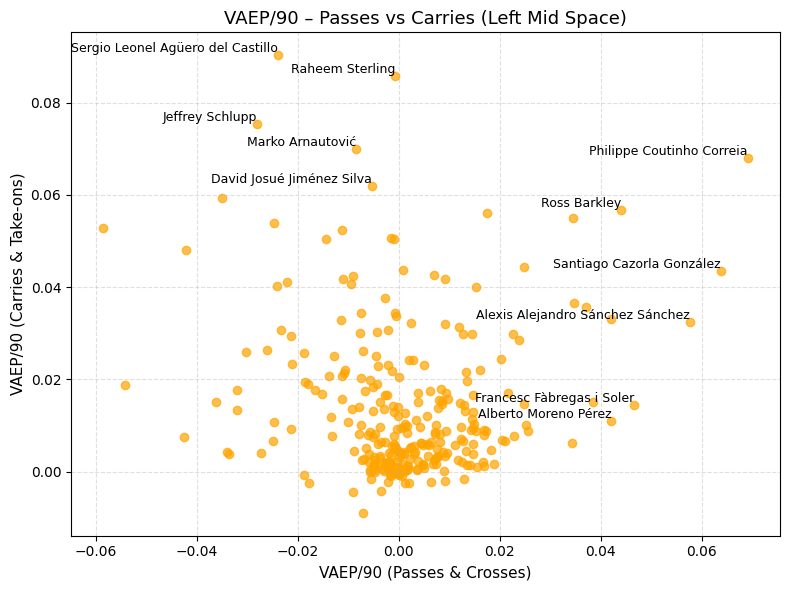

In [5]:
plt.figure(figsize=(8, 6))

summary['vaep_per90_pass_cross'] = summary['vaep_per90_pass_cross'].fillna(0)
summary['vaep_per90_carry_takeon'] = summary['vaep_per90_carry_takeon'].fillna(0)

plt.scatter(
    summary['vaep_per90_pass_cross'],
    summary['vaep_per90_carry_takeon'],
    color='orange',
    alpha=0.7
)

highlight = summary[
    (summary['vaep_per90_pass_cross'] > summary['vaep_per90_pass_cross'].quantile(0.98)) |
    (summary['vaep_per90_carry_takeon'] > summary['vaep_per90_carry_takeon'].quantile(0.98))
]

for _, row in highlight.iterrows():
    plt.text(
        row['vaep_per90_pass_cross'],
        row['vaep_per90_carry_takeon'],
        row['player_name'],
        fontsize=9,
        ha='right',
        va='bottom',
        color='black'
    )

plt.xlabel('VAEP/90 (Passes & Crosses)', fontsize=11)
plt.ylabel('VAEP/90 (Carries & Take-ons)', fontsize=11)
plt.title('VAEP/90 – Passes vs Carries (Left Mid Space)', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [6]:
summary['vaep_per90_pass_cross'] = summary['vaep_per90_pass_cross'].round(2)
summary['total_minutes'] = summary['total_minutes'].round(2)

top10 = summary.sort_values('vaep_per90_pass_cross', ascending=False).head(10)

table = top10[['player_name', 'vaep_per90_pass_cross', 'total_minutes']]

print("\nTop VAEP generators in left mid offensive space (min 1000 minutes):")
print(tabulate(table, headers=["Player", "VAEP/90 Pass-Cross", "Minutes"], tablefmt="pretty", showindex=False, colalign=("left", "right", "right")))



Top VAEP generators in left mid offensive space (min 1000 minutes):
+----------------------------------+--------------------+---------+
| Player                           | VAEP/90 Pass-Cross | Minutes |
+----------------------------------+--------------------+---------+
| Philippe Coutinho Correia        |               0.07 |  2097.0 |
| Santiago Cazorla González        |               0.06 |  1349.0 |
| Alexis Alejandro Sánchez Sánchez |               0.06 |  2510.0 |
| Francesc Fàbregas i Soler        |               0.05 |  3030.0 |
| Mesut Özil                       |               0.04 |  3125.0 |
| Aaron Ramsey                     |               0.04 |  2732.0 |
| Ross Barkley                     |               0.04 |  3170.0 |
| Alberto Moreno Pérez             |               0.04 |  2671.0 |
| Leighton Baines                  |               0.04 |  1553.0 |
| Junior Stanislas                 |               0.03 |  1487.0 |
+----------------------------------+-----------

In [7]:
summary['vaep_per90_carry_takeon'] = summary['vaep_per90_carry_takeon'].round(2)
summary['total_minutes'] = summary['total_minutes'].round(2)

top10 = summary.sort_values('vaep_per90_carry_takeon', ascending=False).head(10)

table = top10[['player_name', 'vaep_per90_carry_takeon', 'total_minutes']]

print("\nTop VAEP generators in left mid offensive space (min 1000 minutes):")
print(tabulate(
    table,
    headers=["Player", "VAEP/90 Carry-TakeOn", "Minutes"],
    tablefmt="pretty",
    showindex=False,
    colalign=("left", "right", "right")
))



Top VAEP generators in left mid offensive space (min 1000 minutes):
+-----------------------------------+----------------------+---------+
| Player                            | VAEP/90 Carry-TakeOn | Minutes |
+-----------------------------------+----------------------+---------+
| Sergio Leonel Agüero del Castillo |                 0.09 |  2412.0 |
| Raheem Sterling                   |                 0.09 |  1981.0 |
| Jeffrey Schlupp                   |                 0.08 |  1467.0 |
| Marko Arnautović                  |                 0.07 |  2888.0 |
| Philippe Coutinho Correia         |                 0.07 |  2097.0 |
| Anthony Martial                   |                 0.06 |  2741.0 |
| Memphis Depay                     |                 0.06 |  1576.0 |
| Ross Barkley                      |                 0.06 |  3170.0 |
| David Josué Jiménez Silva         |                 0.06 |  1831.0 |
| Jefferson Antonio Montero Vite    |                 0.05 |  1409.0 |
+-------